In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras import layers
from keras.models import Model
data=pd.read_csv("ner_dataset.csv",encoding="latin1")

In [26]:
data=data.fillna(method="ffill")
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [27]:
words=list(data['Word'].unique())
words.append("ENDPAD")
tags=list(data['Tag'].unique())
num_words = len(words)
num_tags = len(tags)

In [28]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [29]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [30]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

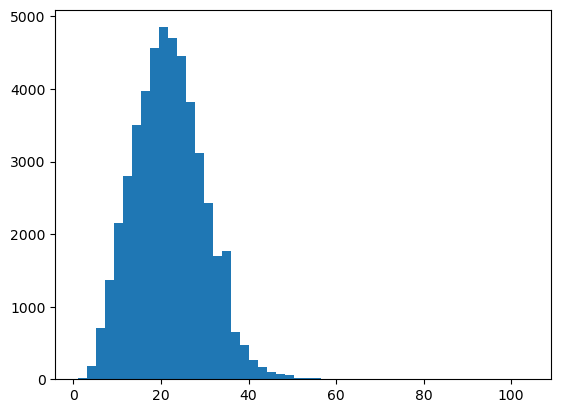

In [31]:
import matplotlib.pyplot as plt
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [32]:
X1 = [[word2idx[w[0]] for w in s] for s in sentences]
max_len = 60
X = sequence.pad_sequences(maxlen=max_len,
                  sequences=X1, padding="post",
                  value=num_words-1)
y1 = [[tag2idx[w[2]] for w in s] for s in sentences]
y = sequence.pad_sequences(maxlen=max_len,
                  sequences=y1,
                  padding="post",
                  value=tag2idx["O"])

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=1)
input_word = layers.Input(shape=(max_len,))
embedding_layer=layers.Embedding(num_words,60)(input_word)
drop_layer=layers.SpatialDropout1D(0.2)(embedding_layer)
b_layer=layers.Bidirectional(layers.LSTM(units=100,return_sequences=True,recurrent_dropout=0.2))(drop_layer)
output=layers.TimeDistributed(layers.Dense(num_tags,activation='softmax'))(b_layer)
model = Model(input_word, output)

In [34]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [35]:
print("X_train shape:",X_train.shape)
print("Y_train shape:",y_train.shape)

X_train shape: (38367, 60)
Y_train shape: (38367, 60)


In [36]:
history = model.fit(
    x=X_train,
    y=y_train, 
    validation_data=(X_test,y_test),
    epochs=3,
)

Epoch 1/3
1199/1199 [==============================] - 278s 227ms/step - loss: 0.1504 - accuracy: 0.9658 - val_loss: 0.0551 - val_accuracy: 0.9844
Epoch 2/3
1199/1199 [==============================] - 259s 216ms/step - loss: 0.0432 - accuracy: 0.9872 - val_loss: 0.0428 - val_accuracy: 0.9873
Epoch 3/3
1199/1199 [==============================] - 261s 217ms/step - loss: 0.0320 - accuracy: 0.9902 - val_loss: 0.0403 - val_accuracy: 0.9880


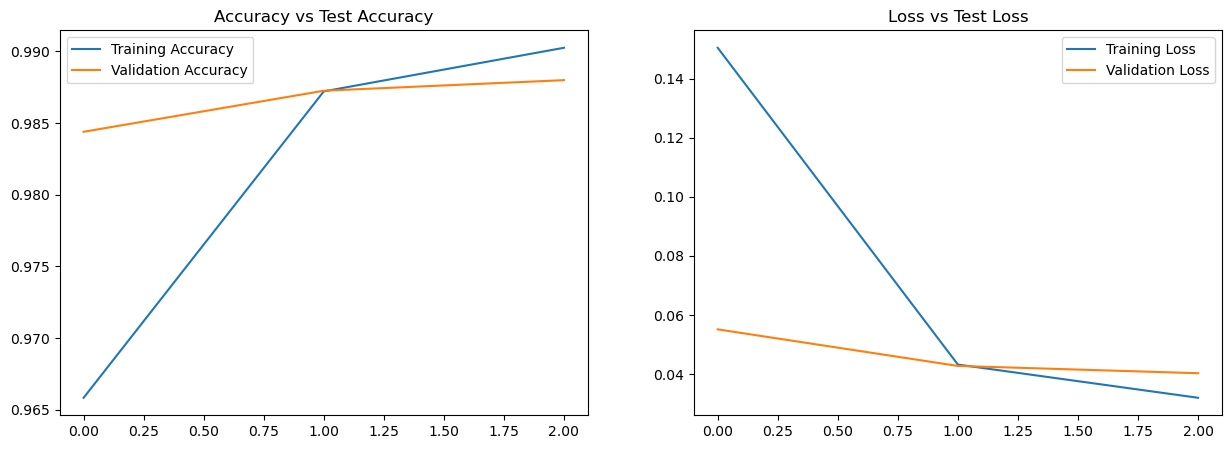

In [37]:
metrics = pd.DataFrame(model.history.history)
metrics.iloc[metrics.shape[0]-1,:]
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(metrics[['accuracy','val_accuracy']])
plt.legend(["Training Accuracy","Validation Accuracy"])
plt.title("Accuracy vs Test Accuracy")
plt.subplot(1,2,2)
plt.plot(metrics[['loss','val_loss']])
plt.legend(["Training Loss","Validation Loss"])
plt.title("Loss vs Test Loss")
plt.show()

In [53]:
import random
lst_pred=(random.choices(words,k=20))
X_pred = [[word2idx[w] for w in lst_pred]]
pred_inp= sequence.pad_sequences(maxlen=max_len,
                  sequences=X_pred, padding="post",
                  value=num_words-1)
prediction=model.predict(np.array(pred_inp))
prediction = np.argmax(prediction, axis=-1)
print("  {:25}\t{}".format("Word","Predicted Tag"))
for y,x in zip(lst_pred,prediction[0]):
  print("{:25}\t     {}".format(y,tags[x]))

  Word                     	Predicted Tag
prince                   	     O
associate                	     O
Field                    	     O
adjourned                	     O
Letterman                	     O
seek                     	     O
Sadrists                 	     O
U.S.-bound               	     O
Rains                    	     O
musicians                	     O
unexplored               	     O
Blizzard-like            	     O
Lopez-Alegria            	     O
shoot-out                	     O
uproot                   	     O
53,000                   	     O
Curtailing               	     O
mutate                   	     O
projectiles              	     O
powerful                 	     O
